In [7]:
!pip install opencv-python matplotlib seaborn

  Using cached opencv_python-4.12.0.88-cp37-abi3-win_amd64.whl.metadata (19 kB)
  Using cached matplotlib-3.10.5-cp312-cp312-win_amd64.whl.metadata (11 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached numpy-2.2.6-cp312-cp312-win_amd64.whl.metadata (60 kB)
  Using cached contourpy-1.3.3-cp312-cp312-win_amd64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.59.0-cp312-cp312-win_amd64.whl.metadata (110 kB)
  Using cached kiwisolver-1.4.8-cp312-cp312-win_amd64.whl.metadata (6.3 kB)
  Using cached pillow-11.3.0-cp312-cp312-win_amd64.whl.metadata (9.2 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
Using cached opencv_python-4.12.0.88-cp37-abi3-win_amd64.whl (39.0 MB)
Using cached matplotlib-3.10.5-cp312-cp312-win_amd64.whl (8.1 MB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Using cached contourpy-1.3.3-cp312-cp312-win_amd64.whl (226 kB)
Using cached cycler-0.12


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
import cv2
import numpy as np
import os
from glob import glob
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [9]:
base_dir = '/Users/maks2/OneDrive/projects/retina-segmentation/Data'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

train_image_path = os.path.join(train_dir, 'image')
train_mask_path = os.path.join(train_dir, 'mask')

test_image_path = os.path.join(test_dir, 'image')
test_mask_path = os.path.join(test_dir, 'mask')

In [10]:
paired_train_images = []
paired_train_masks = []

for img_path in sorted(glob(os.path.join(train_image_path, '*.png'))):
    basename = os.path.basename(img_path)
    expected_mask_path = os.path.join(train_mask_path, basename)

    
    if os.path.exists(expected_mask_path):
        # Нормализуем пути для корректного сравнения
        normalized_img_path = os.path.normpath(img_path)
        normalized_mask_path = os.path.normpath(expected_mask_path)

        paired_train_images.append(normalized_img_path)
        paired_train_masks.append(normalized_mask_path)

print(f"Найдено {len(paired_train_images)} пар в тренировочной выборке")

Найдено 80 пар в тренировочной выборке


In [11]:
paired_train_images[1:10], paired_train_masks[1:10]

(['\\Users\\maks2\\OneDrive\\projects\\retina-segmentation\\Data\\train\\image\\1.png',
  '\\Users\\maks2\\OneDrive\\projects\\retina-segmentation\\Data\\train\\image\\10.png',
  '\\Users\\maks2\\OneDrive\\projects\\retina-segmentation\\Data\\train\\image\\11.png',
  '\\Users\\maks2\\OneDrive\\projects\\retina-segmentation\\Data\\train\\image\\12.png',
  '\\Users\\maks2\\OneDrive\\projects\\retina-segmentation\\Data\\train\\image\\13.png',
  '\\Users\\maks2\\OneDrive\\projects\\retina-segmentation\\Data\\train\\image\\14.png',
  '\\Users\\maks2\\OneDrive\\projects\\retina-segmentation\\Data\\train\\image\\15.png',
  '\\Users\\maks2\\OneDrive\\projects\\retina-segmentation\\Data\\train\\image\\16.png',
  '\\Users\\maks2\\OneDrive\\projects\\retina-segmentation\\Data\\train\\image\\17.png'],
 ['\\Users\\maks2\\OneDrive\\projects\\retina-segmentation\\Data\\train\\mask\\1.png',
  '\\Users\\maks2\\OneDrive\\projects\\retina-segmentation\\Data\\train\\mask\\10.png',
  '\\Users\\maks2\\OneDr

In [12]:
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
print(img.shape if img is not None else "Image could not be loaded")

(512, 512)


In [13]:
def show_img_mask(img_path: str, mask_path: str, number: int):
    """Визуализирует изображение с маской по заданному порядковому номеру"""
    img_show = cv2.imread(img_path[number], cv2.IMREAD_GRAYSCALE)
    mask_show = cv2.imread(mask_path[number], cv2.IMREAD_GRAYSCALE)

    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.imshow(img_show)
    plt.title('Img')

    plt.subplot(1, 2, 2)
    plt.imshow(mask_show)
    plt.title('Mask')

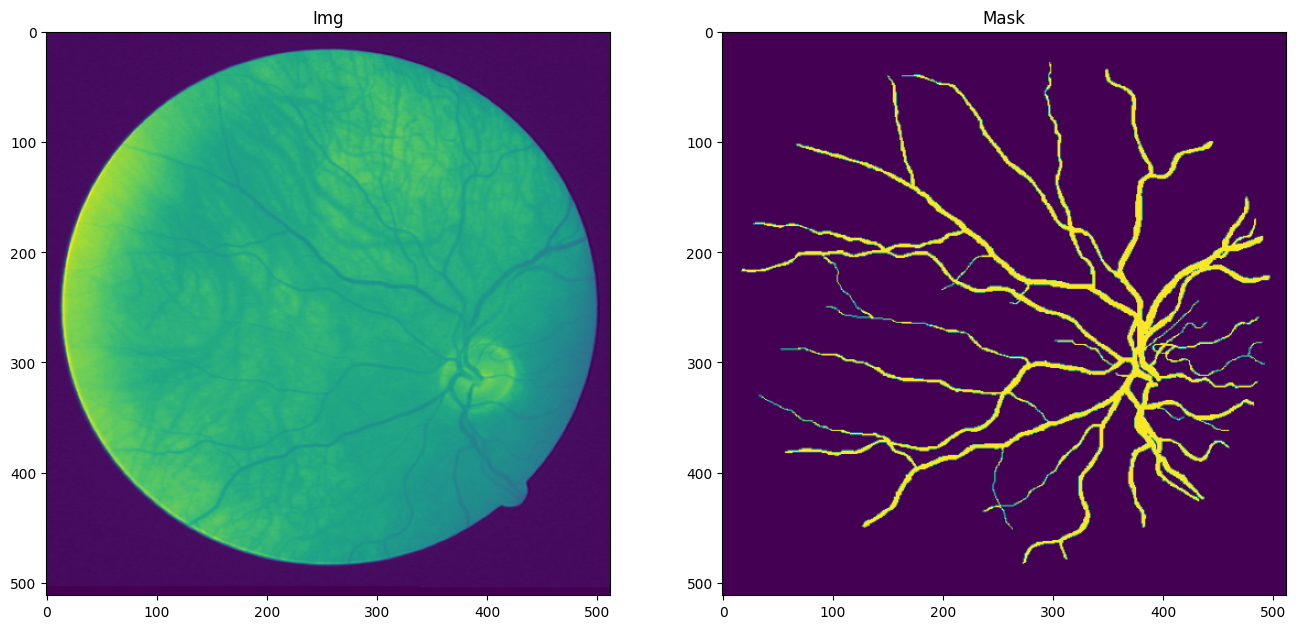

In [14]:
show_img_mask(paired_train_images, paired_train_masks, 2)

In [15]:
data_info = []
for img_path, mask_path in zip(paired_train_images, paired_train_masks):
    # Читаем размеры, не загружая все изображение в память
    img_shape = cv2.imread(img_path).shape
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    
    # Считаем долю пикселей, принадлежащих сосудам
    # Это ключевая метрика для понимания дисбаланса классов
    vessel_area_ratio = np.sum(mask > 0) / (mask.shape[0] * mask.shape[1])
    
    data_info.append({
        'image_path': img_path,
        'mask_path': mask_path,
        'height': img_shape[0],
        'width': img_shape[1],
        'vessel_ratio': vessel_area_ratio
    })

In [16]:
df = pd.DataFrame(data_info)
print("\nПервые 5 строк собранной информации:")
print(df.head())


Первые 5 строк собранной информации:
                                          image_path  \
0  \Users\maks2\OneDrive\projects\retina-segmenta...   
1  \Users\maks2\OneDrive\projects\retina-segmenta...   
2  \Users\maks2\OneDrive\projects\retina-segmenta...   
3  \Users\maks2\OneDrive\projects\retina-segmenta...   
4  \Users\maks2\OneDrive\projects\retina-segmenta...   

                                           mask_path  height  width  \
0  \Users\maks2\OneDrive\projects\retina-segmenta...     512    512   
1  \Users\maks2\OneDrive\projects\retina-segmenta...     512    512   
2  \Users\maks2\OneDrive\projects\retina-segmenta...     512    512   
3  \Users\maks2\OneDrive\projects\retina-segmenta...     512    512   
4  \Users\maks2\OneDrive\projects\retina-segmenta...     512    512   

   vessel_ratio  
0      0.105225  
1      0.105225  
2      0.088673  
3      0.096264  
4      0.159134  


In [17]:
print("\n--- Анализ размеров изображений ---")
size_counts = df.groupby(['height', 'width']).size().reset_index(name='count')
print(size_counts)

if len(size_counts) > 1:
    print("\nВНИМАНИЕ: Изображения имеют разные размеры. Resize обязателен.")
else:
    print("\nВсе изображения имеют одинаковый размер.")


--- Анализ размеров изображений ---
   height  width  count
0     512    512     80

Все изображения имеют одинаковый размер.



--- Анализ дисбаланса классов (доля сосудов на изображении) ---


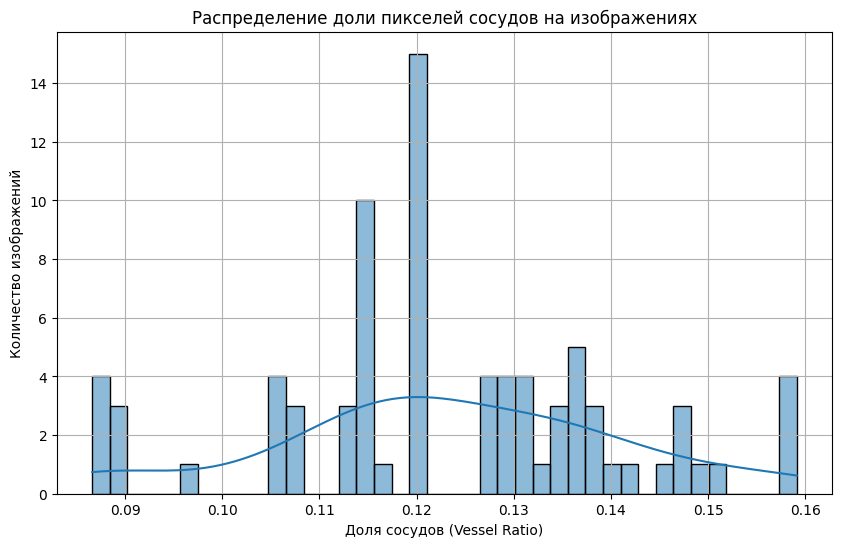


Средняя доля пикселей сосудов на изображении: 0.1232


In [18]:
print("\n--- Анализ дисбаланса классов (доля сосудов на изображении) ---")
plt.figure(figsize=(10, 6))
sns.histplot(df['vessel_ratio'], bins=40, kde=True)
plt.title('Распределение доли пикселей сосудов на изображениях')
plt.xlabel('Доля сосудов (Vessel Ratio)')
plt.ylabel('Количество изображений')
plt.grid(True)
plt.show()

mean_ratio = df['vessel_ratio'].mean()
print(f"\nСредняя доля пикселей сосудов на изображении: {mean_ratio:.4f}")